# Face Generation
In this project, we will use generative adversarial networks to generate new images of digts, faces and arts.


### Get the Data
We use 3 datasets in this project:
- MNIST
- CelebA
- Impressionism

They get saved in `/data`


In [3]:
data_dir = '/data'

In [4]:
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)
#helper.download_extract('impressionism', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. We show the first number of examples by changing `show_n_images`. 

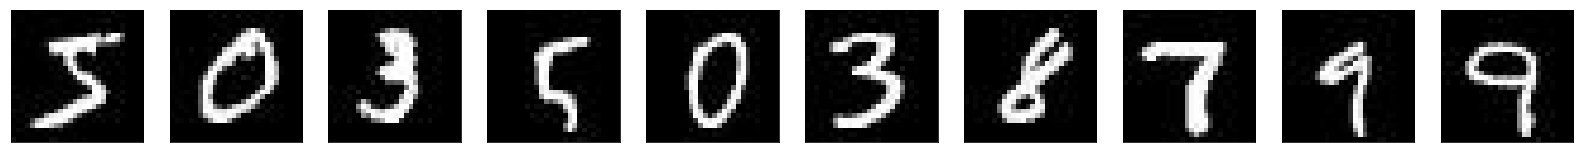

In [5]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import helper

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
mnist_images = mnist_images.reshape(show_n_images,28,28)
fig = pyplot.figure(figsize=(28,28))
for i in range(show_n_images):
    ax = fig.add_subplot(1, show_n_images, i+1, xticks=[], yticks=[])
    ax.imshow(mnist_images[i], cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. We discard the annotations and show the first number of examples by using `show_n_images`.

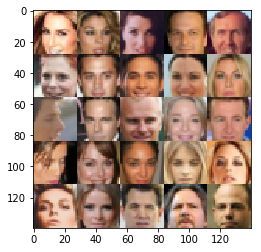

In [6]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### Impressionism
The impressionist dataset.

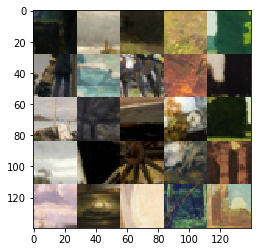

In [7]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'impressionism/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data

The used data is preprocessed and cropped and resized (to have a one fit all model).  

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network
To build a GANs in this notebook we implement the following functions:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU

In [13]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

In [14]:
print(tf.__version__)

1.10.0


In [15]:
config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0,1"

In [16]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [17]:
get_available_gpus()[0]

'/device:GPU:0'

### Input
Implements the `model_inputs` function to create TF Placeholders for the Neural Network. It creates the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Returns the placeholders in the tuple (tensor of real input images, tensor of z data)

In [18]:
#import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learn_rate



### Discriminator
Implements `discriminator` to create a discriminator neural network that discriminates on `images`.  This function reuses the variables in the neural network.  Uses [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function returns a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
    # Input layer is 28x28x3 or 28x28x1        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        dropout1 = tf.layers.dropout(relu1, rate=0.4)
        # 14x14x64
        
        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropout2 = tf.layers.dropout(relu2, rate=0.4)
        # 7x7x128
        
        x3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropout3 = tf.layers.dropout(relu3, rate=0.4)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits




### Generator
Implements `generator` to generate an image using `z`. This function reuses the variables in the neural network.  Uses [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. 

In [20]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) #leaky relu
        dropout1 = tf.layers.dropout(x1, rate=0.4)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        dropout2 = tf.layers.dropout(x2, rate=0.4)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
    




### Loss
Implements `model_loss` to build the GANs for training and calculate the loss.  The function returns a tuple of (discriminator loss, generator loss). 

In [21]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoother = 0.9
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smoother))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*smoother))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss




### Optimization
Implements `model_opt` to create the optimization operations for the GANs. Uses [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filters the variables with names that are in the discriminator and generator scope names.  The function returns a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt




## Neural Network Training
### Show Output
function to show the current output of the generator during training.

In [23]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implements `train` to build and train the GANs.  

Uses the `show_generator_output` to show `generator` output while training. 

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          print_every=10, show_every=100, alpha = 0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
       
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)     
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images*2, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images*2, learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2, learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, learn_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:                    
                    show_generator_output(sess, 1, input_z,  data_shape[3], data_image_mode)
                    
                
                

### MNIST
GANs architecture on MNIST.

Epoch 1/4... Discriminator Loss: 0.4797... Generator Loss: 2.5266
Epoch 1/4... Discriminator Loss: 1.8030... Generator Loss: 0.8061
Epoch 1/4... Discriminator Loss: 0.5310... Generator Loss: 4.4847
Epoch 1/4... Discriminator Loss: 1.5504... Generator Loss: 2.1033
Epoch 1/4... Discriminator Loss: 0.6961... Generator Loss: 1.6196
Epoch 1/4... Discriminator Loss: 1.0310... Generator Loss: 1.0806
Epoch 1/4... Discriminator Loss: 1.0507... Generator Loss: 0.8914
Epoch 1/4... Discriminator Loss: 1.1713... Generator Loss: 1.8768
Epoch 1/4... Discriminator Loss: 1.1933... Generator Loss: 1.2357
Epoch 1/4... Discriminator Loss: 1.0612... Generator Loss: 0.9635


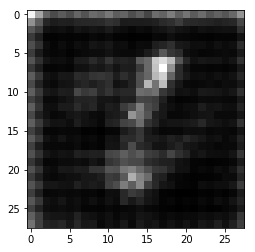

Epoch 1/4... Discriminator Loss: 1.1023... Generator Loss: 1.6614
Epoch 1/4... Discriminator Loss: 1.1123... Generator Loss: 0.8302
Epoch 1/4... Discriminator Loss: 1.2093... Generator Loss: 0.7291
Epoch 1/4... Discriminator Loss: 1.0576... Generator Loss: 0.9616
Epoch 1/4... Discriminator Loss: 1.3645... Generator Loss: 0.5929
Epoch 1/4... Discriminator Loss: 1.1321... Generator Loss: 1.0181
Epoch 1/4... Discriminator Loss: 1.2806... Generator Loss: 0.6941
Epoch 1/4... Discriminator Loss: 1.2447... Generator Loss: 1.7716
Epoch 1/4... Discriminator Loss: 0.8788... Generator Loss: 1.1208
Epoch 1/4... Discriminator Loss: 0.9540... Generator Loss: 1.3431


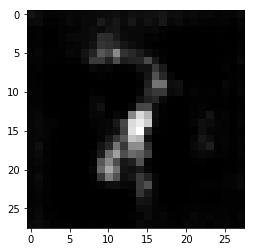

Epoch 1/4... Discriminator Loss: 0.9487... Generator Loss: 1.4490
Epoch 1/4... Discriminator Loss: 0.9468... Generator Loss: 1.1472
Epoch 1/4... Discriminator Loss: 0.9762... Generator Loss: 0.9686
Epoch 1/4... Discriminator Loss: 1.0742... Generator Loss: 0.8102
Epoch 1/4... Discriminator Loss: 1.0787... Generator Loss: 1.8935
Epoch 1/4... Discriminator Loss: 0.9946... Generator Loss: 2.0398
Epoch 1/4... Discriminator Loss: 0.7333... Generator Loss: 1.7004
Epoch 1/4... Discriminator Loss: 1.4093... Generator Loss: 0.6203
Epoch 1/4... Discriminator Loss: 0.8320... Generator Loss: 1.3861
Epoch 1/4... Discriminator Loss: 0.9400... Generator Loss: 0.9011


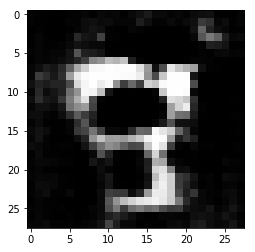

Epoch 1/4... Discriminator Loss: 1.2823... Generator Loss: 0.6107
Epoch 1/4... Discriminator Loss: 0.9626... Generator Loss: 1.8205
Epoch 1/4... Discriminator Loss: 1.0905... Generator Loss: 1.6626
Epoch 1/4... Discriminator Loss: 1.0604... Generator Loss: 1.4921
Epoch 1/4... Discriminator Loss: 1.0895... Generator Loss: 1.9613
Epoch 1/4... Discriminator Loss: 1.0091... Generator Loss: 0.8852
Epoch 1/4... Discriminator Loss: 1.1204... Generator Loss: 1.9058
Epoch 1/4... Discriminator Loss: 0.9289... Generator Loss: 1.0282
Epoch 1/4... Discriminator Loss: 1.0722... Generator Loss: 0.9314
Epoch 1/4... Discriminator Loss: 0.9994... Generator Loss: 1.3604


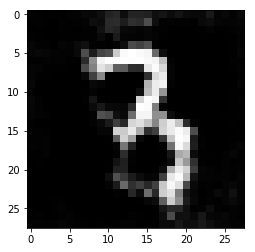

Epoch 1/4... Discriminator Loss: 1.2597... Generator Loss: 2.4397
Epoch 1/4... Discriminator Loss: 0.8412... Generator Loss: 1.2019
Epoch 1/4... Discriminator Loss: 1.1478... Generator Loss: 2.2102
Epoch 1/4... Discriminator Loss: 0.8939... Generator Loss: 1.0701
Epoch 1/4... Discriminator Loss: 0.9680... Generator Loss: 1.6422
Epoch 1/4... Discriminator Loss: 0.9139... Generator Loss: 1.0466
Epoch 2/4... Discriminator Loss: 1.0081... Generator Loss: 1.1294
Epoch 2/4... Discriminator Loss: 0.9458... Generator Loss: 1.0780
Epoch 2/4... Discriminator Loss: 0.9812... Generator Loss: 0.9846
Epoch 2/4... Discriminator Loss: 1.1721... Generator Loss: 0.7002


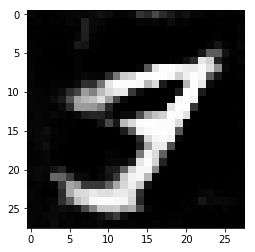

Epoch 2/4... Discriminator Loss: 1.1256... Generator Loss: 0.8247
Epoch 2/4... Discriminator Loss: 1.1108... Generator Loss: 0.7924
Epoch 2/4... Discriminator Loss: 1.0903... Generator Loss: 0.9056
Epoch 2/4... Discriminator Loss: 1.0401... Generator Loss: 0.9978
Epoch 2/4... Discriminator Loss: 1.0462... Generator Loss: 1.4992
Epoch 2/4... Discriminator Loss: 0.8610... Generator Loss: 1.2543
Epoch 2/4... Discriminator Loss: 0.9864... Generator Loss: 0.9245
Epoch 2/4... Discriminator Loss: 0.9446... Generator Loss: 1.3134
Epoch 2/4... Discriminator Loss: 1.1256... Generator Loss: 1.4550
Epoch 2/4... Discriminator Loss: 0.8601... Generator Loss: 1.2137


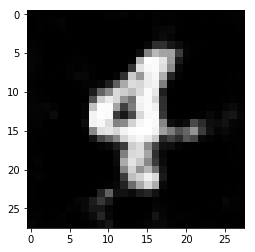

Epoch 2/4... Discriminator Loss: 1.0775... Generator Loss: 0.8007
Epoch 2/4... Discriminator Loss: 1.2508... Generator Loss: 0.6942
Epoch 2/4... Discriminator Loss: 1.0401... Generator Loss: 0.8609
Epoch 2/4... Discriminator Loss: 1.2838... Generator Loss: 0.7015
Epoch 2/4... Discriminator Loss: 1.0957... Generator Loss: 0.7597
Epoch 2/4... Discriminator Loss: 1.0707... Generator Loss: 1.2537
Epoch 2/4... Discriminator Loss: 0.9544... Generator Loss: 1.4738
Epoch 2/4... Discriminator Loss: 0.8819... Generator Loss: 1.2212
Epoch 2/4... Discriminator Loss: 0.8643... Generator Loss: 1.6325
Epoch 2/4... Discriminator Loss: 1.4854... Generator Loss: 0.5467


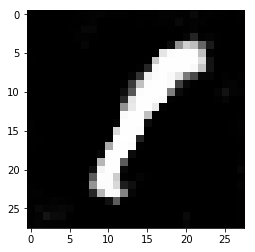

Epoch 2/4... Discriminator Loss: 0.9985... Generator Loss: 0.9796
Epoch 2/4... Discriminator Loss: 0.8298... Generator Loss: 1.1427
Epoch 2/4... Discriminator Loss: 0.9395... Generator Loss: 1.5515
Epoch 2/4... Discriminator Loss: 0.8283... Generator Loss: 1.3453
Epoch 2/4... Discriminator Loss: 2.4740... Generator Loss: 0.4393
Epoch 2/4... Discriminator Loss: 0.8115... Generator Loss: 1.2837
Epoch 2/4... Discriminator Loss: 0.8552... Generator Loss: 1.1410
Epoch 2/4... Discriminator Loss: 0.8656... Generator Loss: 1.3222
Epoch 2/4... Discriminator Loss: 0.8470... Generator Loss: 1.1083
Epoch 2/4... Discriminator Loss: 1.0541... Generator Loss: 1.3057


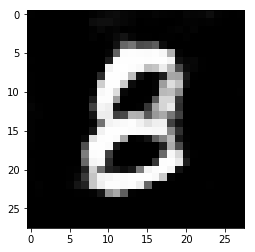

Epoch 2/4... Discriminator Loss: 0.8702... Generator Loss: 1.0854
Epoch 2/4... Discriminator Loss: 0.8332... Generator Loss: 1.2133
Epoch 2/4... Discriminator Loss: 0.8697... Generator Loss: 1.0911
Epoch 2/4... Discriminator Loss: 0.8746... Generator Loss: 1.7413
Epoch 2/4... Discriminator Loss: 1.0301... Generator Loss: 0.8614
Epoch 2/4... Discriminator Loss: 0.8840... Generator Loss: 1.0064
Epoch 2/4... Discriminator Loss: 0.8770... Generator Loss: 1.1020
Epoch 2/4... Discriminator Loss: 0.7909... Generator Loss: 1.1838
Epoch 2/4... Discriminator Loss: 0.7967... Generator Loss: 2.0364
Epoch 2/4... Discriminator Loss: 2.1080... Generator Loss: 3.3287


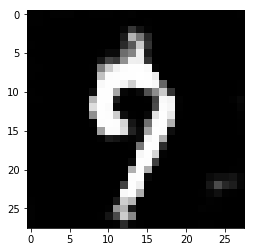

Epoch 2/4... Discriminator Loss: 0.9963... Generator Loss: 0.9332
Epoch 2/4... Discriminator Loss: 0.7798... Generator Loss: 1.6481
Epoch 2/4... Discriminator Loss: 0.7255... Generator Loss: 1.2579
Epoch 3/4... Discriminator Loss: 1.2252... Generator Loss: 2.2647
Epoch 3/4... Discriminator Loss: 0.9022... Generator Loss: 1.0731
Epoch 3/4... Discriminator Loss: 0.9721... Generator Loss: 0.8340
Epoch 3/4... Discriminator Loss: 0.7045... Generator Loss: 1.4528
Epoch 3/4... Discriminator Loss: 0.8779... Generator Loss: 0.9809
Epoch 3/4... Discriminator Loss: 0.8390... Generator Loss: 1.0867
Epoch 3/4... Discriminator Loss: 0.9920... Generator Loss: 0.9171


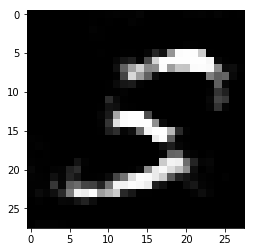

Epoch 3/4... Discriminator Loss: 0.9187... Generator Loss: 0.9600
Epoch 3/4... Discriminator Loss: 0.9500... Generator Loss: 0.9112
Epoch 3/4... Discriminator Loss: 0.9456... Generator Loss: 0.9066
Epoch 3/4... Discriminator Loss: 0.8531... Generator Loss: 1.4016
Epoch 3/4... Discriminator Loss: 1.0143... Generator Loss: 0.8619
Epoch 3/4... Discriminator Loss: 0.8007... Generator Loss: 1.2195
Epoch 3/4... Discriminator Loss: 2.6548... Generator Loss: 3.6129
Epoch 3/4... Discriminator Loss: 1.0216... Generator Loss: 1.1850
Epoch 3/4... Discriminator Loss: 0.9797... Generator Loss: 1.9101
Epoch 3/4... Discriminator Loss: 0.6899... Generator Loss: 1.5468


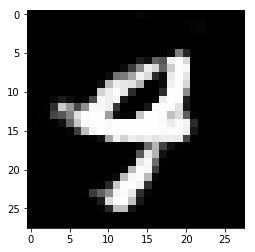

Epoch 3/4... Discriminator Loss: 1.0394... Generator Loss: 2.0984
Epoch 3/4... Discriminator Loss: 0.8245... Generator Loss: 1.1279
Epoch 3/4... Discriminator Loss: 1.1819... Generator Loss: 0.6857
Epoch 3/4... Discriminator Loss: 0.7227... Generator Loss: 1.2201
Epoch 3/4... Discriminator Loss: 1.3358... Generator Loss: 0.5980
Epoch 3/4... Discriminator Loss: 1.5106... Generator Loss: 0.5473
Epoch 3/4... Discriminator Loss: 0.8900... Generator Loss: 1.0228
Epoch 3/4... Discriminator Loss: 0.9464... Generator Loss: 0.8993
Epoch 3/4... Discriminator Loss: 0.7534... Generator Loss: 1.8962
Epoch 3/4... Discriminator Loss: 0.9640... Generator Loss: 0.9100


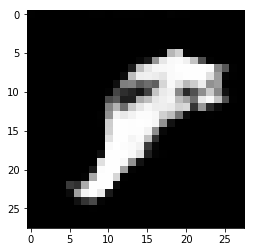

Epoch 3/4... Discriminator Loss: 0.9007... Generator Loss: 0.9258
Epoch 3/4... Discriminator Loss: 1.1623... Generator Loss: 0.7084
Epoch 3/4... Discriminator Loss: 0.7191... Generator Loss: 1.4015
Epoch 3/4... Discriminator Loss: 0.8982... Generator Loss: 1.0073
Epoch 3/4... Discriminator Loss: 0.7568... Generator Loss: 1.7500
Epoch 3/4... Discriminator Loss: 0.9278... Generator Loss: 0.9940
Epoch 3/4... Discriminator Loss: 0.8243... Generator Loss: 1.2750
Epoch 3/4... Discriminator Loss: 1.0922... Generator Loss: 0.7460
Epoch 3/4... Discriminator Loss: 1.0411... Generator Loss: 0.8475
Epoch 3/4... Discriminator Loss: 0.7808... Generator Loss: 1.0902


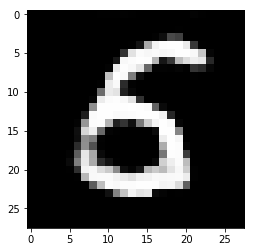

Epoch 3/4... Discriminator Loss: 0.9125... Generator Loss: 1.7655
Epoch 3/4... Discriminator Loss: 0.8690... Generator Loss: 1.0053
Epoch 3/4... Discriminator Loss: 0.8742... Generator Loss: 1.0108
Epoch 3/4... Discriminator Loss: 0.8868... Generator Loss: 1.0567
Epoch 3/4... Discriminator Loss: 0.8151... Generator Loss: 2.3207
Epoch 3/4... Discriminator Loss: 0.6328... Generator Loss: 1.6682
Epoch 3/4... Discriminator Loss: 1.3042... Generator Loss: 1.3226
Epoch 3/4... Discriminator Loss: 0.7944... Generator Loss: 1.5622
Epoch 3/4... Discriminator Loss: 1.0932... Generator Loss: 0.7831
Epoch 3/4... Discriminator Loss: 0.7856... Generator Loss: 1.5685


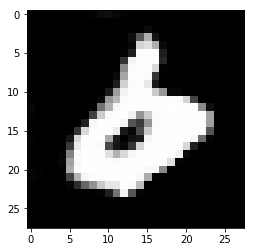

Epoch 4/4... Discriminator Loss: 0.9178... Generator Loss: 0.9833
Epoch 4/4... Discriminator Loss: 0.8070... Generator Loss: 1.3536
Epoch 4/4... Discriminator Loss: 1.2895... Generator Loss: 0.6320
Epoch 4/4... Discriminator Loss: 0.6637... Generator Loss: 1.4098
Epoch 4/4... Discriminator Loss: 0.7966... Generator Loss: 1.0893
Epoch 4/4... Discriminator Loss: 1.0502... Generator Loss: 1.0363
Epoch 4/4... Discriminator Loss: 0.9646... Generator Loss: 0.8934
Epoch 4/4... Discriminator Loss: 0.8229... Generator Loss: 1.0870
Epoch 4/4... Discriminator Loss: 0.8938... Generator Loss: 0.9571
Epoch 4/4... Discriminator Loss: 0.8426... Generator Loss: 1.0501


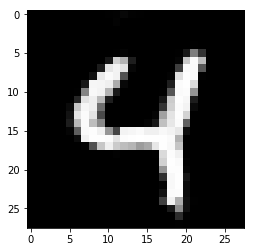

Epoch 4/4... Discriminator Loss: 0.8928... Generator Loss: 2.8698
Epoch 4/4... Discriminator Loss: 1.2289... Generator Loss: 0.7937
Epoch 4/4... Discriminator Loss: 1.2878... Generator Loss: 0.6272
Epoch 4/4... Discriminator Loss: 0.8858... Generator Loss: 0.9564
Epoch 4/4... Discriminator Loss: 1.6869... Generator Loss: 0.4917
Epoch 4/4... Discriminator Loss: 0.7868... Generator Loss: 1.3076
Epoch 4/4... Discriminator Loss: 0.7284... Generator Loss: 1.3181
Epoch 4/4... Discriminator Loss: 0.8801... Generator Loss: 0.9977
Epoch 4/4... Discriminator Loss: 0.8708... Generator Loss: 1.0326
Epoch 4/4... Discriminator Loss: 1.8963... Generator Loss: 0.4566


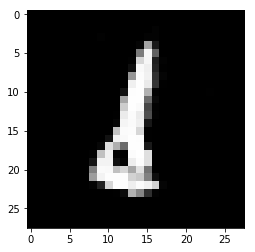

Epoch 4/4... Discriminator Loss: 0.7447... Generator Loss: 1.3669
Epoch 4/4... Discriminator Loss: 0.8717... Generator Loss: 1.0505
Epoch 4/4... Discriminator Loss: 0.7389... Generator Loss: 1.2029
Epoch 4/4... Discriminator Loss: 1.0455... Generator Loss: 0.8720
Epoch 4/4... Discriminator Loss: 0.7473... Generator Loss: 1.2511
Epoch 4/4... Discriminator Loss: 0.9505... Generator Loss: 0.9161
Epoch 4/4... Discriminator Loss: 0.7384... Generator Loss: 2.3852
Epoch 4/4... Discriminator Loss: 1.2118... Generator Loss: 0.7466
Epoch 4/4... Discriminator Loss: 0.7041... Generator Loss: 1.3414
Epoch 4/4... Discriminator Loss: 0.6501... Generator Loss: 1.4385


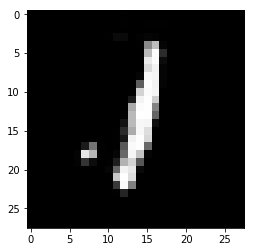

Epoch 4/4... Discriminator Loss: 0.7400... Generator Loss: 1.2290
Epoch 4/4... Discriminator Loss: 0.6464... Generator Loss: 1.9653
Epoch 4/4... Discriminator Loss: 0.6931... Generator Loss: 1.3807
Epoch 4/4... Discriminator Loss: 1.8343... Generator Loss: 4.2891
Epoch 4/4... Discriminator Loss: 0.7645... Generator Loss: 1.2811
Epoch 4/4... Discriminator Loss: 0.6864... Generator Loss: 1.4560
Epoch 4/4... Discriminator Loss: 0.7710... Generator Loss: 1.2734
Epoch 4/4... Discriminator Loss: 0.7743... Generator Loss: 1.9145
Epoch 4/4... Discriminator Loss: 1.0665... Generator Loss: 0.8007
Epoch 4/4... Discriminator Loss: 1.3272... Generator Loss: 0.6310


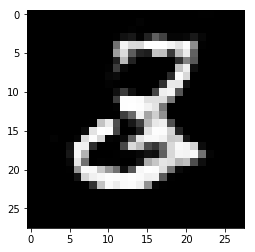

Epoch 4/4... Discriminator Loss: 0.7970... Generator Loss: 1.1627
Epoch 4/4... Discriminator Loss: 0.5739... Generator Loss: 1.7078
Epoch 4/4... Discriminator Loss: 0.6402... Generator Loss: 1.7596
Epoch 4/4... Discriminator Loss: 1.3677... Generator Loss: 2.8574
Epoch 4/4... Discriminator Loss: 0.9778... Generator Loss: 0.9700
Epoch 4/4... Discriminator Loss: 0.9725... Generator Loss: 0.9559
Epoch 4/4... Discriminator Loss: 0.6948... Generator Loss: 1.3503


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
GANs on CelebA.  

Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.5071
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 2.5925
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 1.9080
Epoch 1/1... Discriminator Loss: 1.9539... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 2.1596
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.8779


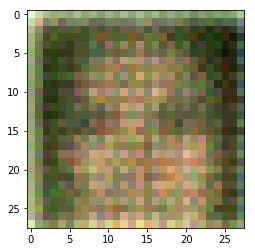

Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 1.4001
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7538


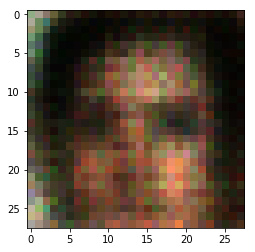

Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.6538
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 2.2134
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.6756


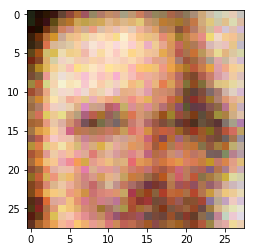

Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 2.7529
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 1.5842


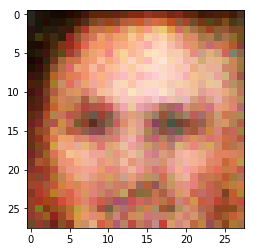

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.8467... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 2.6045... Generator Loss: 0.3421
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 1.0061


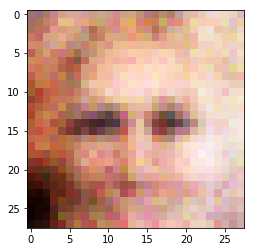

Epoch 1/1... Discriminator Loss: 1.8478... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.3680
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9585


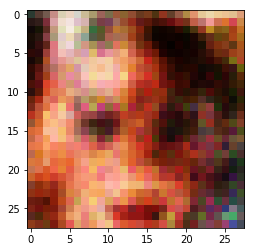

Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 2.3217
Epoch 1/1... Discriminator Loss: 1.6866... Generator Loss: 3.1511
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.8621... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 5.3312


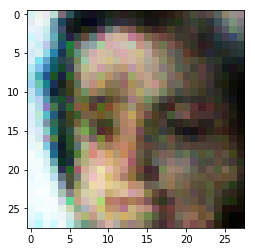

Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 3.0102
Epoch 1/1... Discriminator Loss: 2.2670... Generator Loss: 0.3567
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 3.2508
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.6193
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 3.1599
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 4.6905
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 0.9748


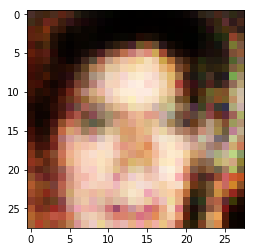

Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.9350
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 4.6956
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 4.3307
Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 6.8032
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 6.7629
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 1.6603


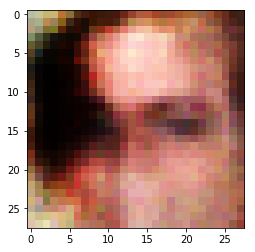

Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 4.2803
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.8026
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 2.8353
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 6.6086
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 5.3442
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 6.8476


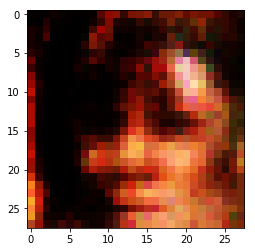

Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 5.2911
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 2.6465
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 4.6477
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 4.4665
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 2.0759
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 5.8682
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 5.6670
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 2.9684


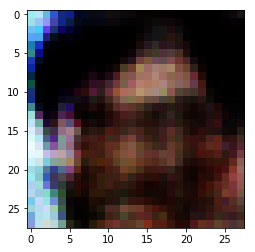

Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 5.2486
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 9.1536
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.5646
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 5.7322
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.3089
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 2.6582
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 3.9215
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 6.5005


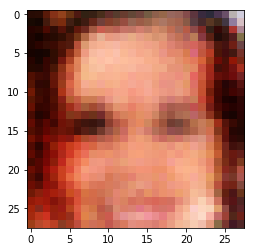

Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 2.6317
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 2.8149
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.1030
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.7694
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 4.6064
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.1936
Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 6.4945
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.1802


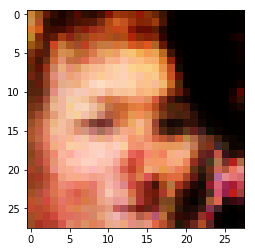

Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 3.2765
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 3.9624
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 3.9345
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 6.7194
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 2.0119


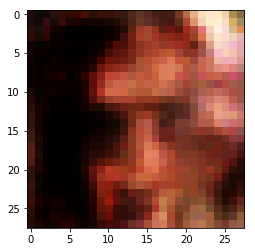

Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 1.8425
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 4.9637
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.0521
Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 5.8104
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 7.8280
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.4701
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 2.4156
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 6.0558


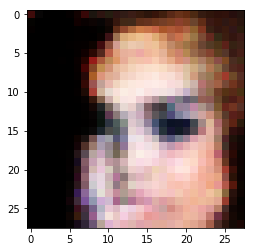

Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 4.3881
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 6.4185
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 4.9785
Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 2.6375
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 7.2650
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 5.0117
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 5.1736
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.3851


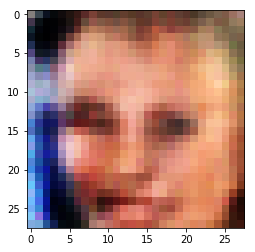

Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 6.1272
Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 5.4252
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 2.3998
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 1.8861
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 5.5723
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 1.9335
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 3.9462


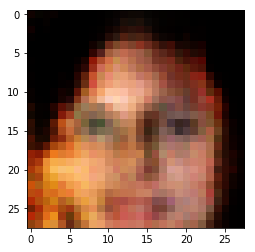

Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 5.0639
Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 3.3752
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 7.1871
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 6.1167
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 5.6890
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 1.9850
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 4.8602
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 5.6420
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.0322


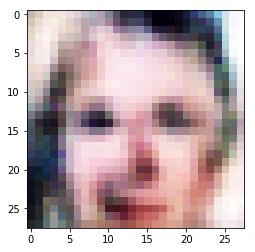

Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 5.7235
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 4.1752
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 2.9405
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 4.4657
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 1.8052
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 2.6326


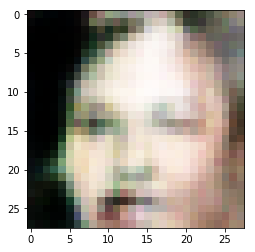

Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 5.1096
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 5.3379
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 4.0886
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 2.3716
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 3.3896
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.4996
Epoch 1/1... Discriminator Loss: 1.6181... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.2798
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 2.2746... Generator Loss: 5.0425


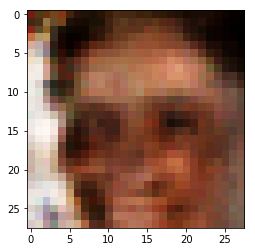

Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 1.6003
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 4.0163
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 2.8302
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 4.6910
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 3.9080
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 1.9523
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.6591
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 5.6231
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 4.3244
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 5.1472


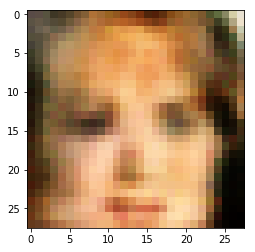

Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 3.3301
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 7.3720
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 2.9386
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 3.4846
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 4.7537
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.4779
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 2.9519
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 3.5009


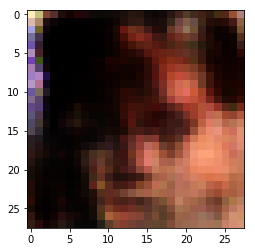

Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 3.8604
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 2.6595
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 4.2348
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 2.6760
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 2.3028
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.6762
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 3.5541
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.7656
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 6.4955
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.2700


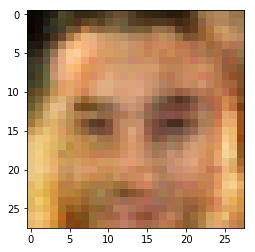

Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 4.5704
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 5.2344
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 6.4615
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 6.6818
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 4.5057
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 2.8341
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 3.1231
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 2.6569
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 5.4364


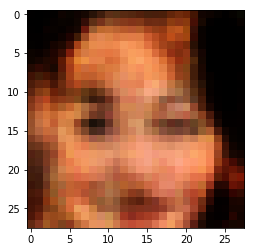

Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 5.8184
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 4.5842
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 3.1117
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 3.0962
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 5.1746
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 4.5327
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 4.3867
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 5.7262


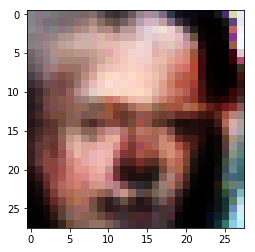

Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 4.7459
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 5.1981
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 3.8311
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 5.7869
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.0778
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 3.6555
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 0.3758... Generator Loss: 3.2622


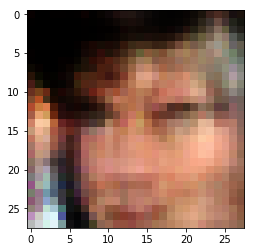

Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 5.9652
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 3.2754
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 4.6114
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.6812
Epoch 1/1... Discriminator Loss: 0.4294... Generator Loss: 2.7920
Epoch 1/1... Discriminator Loss: 2.4608... Generator Loss: 4.2650
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 4.9261
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 6.2439
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 5.3967
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 1.8790


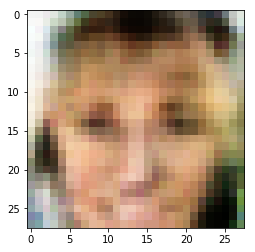

Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 3.1145
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.3285
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 4.4872
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 6.0579
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 2.2400
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 6.3315
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 2.6951
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.0179
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 4.8830


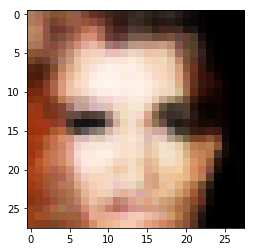

Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 5.2030
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 4.9355
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 3.8223
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 5.0889
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 5.2533
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 7.4755
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.7796
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 5.7141


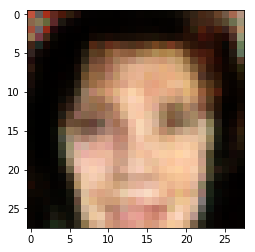

Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 6.7669
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 6.3613
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 1.7482
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 6.8253
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 3.7664
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 2.8878
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 1.4417


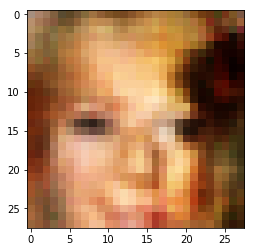

Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.8326
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 3.4243
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.3628
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.2209
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 2.4114
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 4.1412
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.5735
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 6.0126
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 4.6929


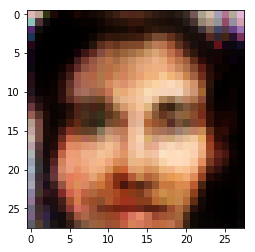

Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 7.9670
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 3.9942
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 4.6496
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 3.9904
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 2.2992
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.5567
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 2.6598
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 2.4477
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 6.5265


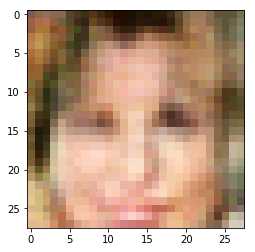

Epoch 1/1... Discriminator Loss: 1.8685... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 4.7170
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.8560
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 2.8458
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 2.8761
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 3.8783


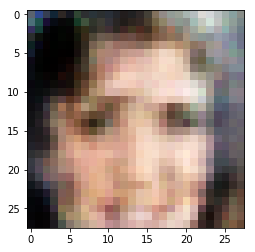

Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 5.4344
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 4.6991
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.9194
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 4.6506
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 3.2461
Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 2.7888


In [34]:
batch_size = 60
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Impressionist
GANs on Impressionist dataset.  

Epoch 1/20... Discriminator Loss: 0.6976... Generator Loss: 14.6308
Epoch 1/20... Discriminator Loss: 0.4415... Generator Loss: 2.4792
Epoch 1/20... Discriminator Loss: 1.1405... Generator Loss: 0.8651
Epoch 1/20... Discriminator Loss: 0.4432... Generator Loss: 3.5567
Epoch 1/20... Discriminator Loss: 1.1505... Generator Loss: 1.7242
Epoch 1/20... Discriminator Loss: 1.4457... Generator Loss: 1.9276
Epoch 1/20... Discriminator Loss: 1.1174... Generator Loss: 0.8730
Epoch 1/20... Discriminator Loss: 0.6632... Generator Loss: 1.7446
Epoch 1/20... Discriminator Loss: 1.1742... Generator Loss: 1.2091
Epoch 1/20... Discriminator Loss: 0.5337... Generator Loss: 2.0486


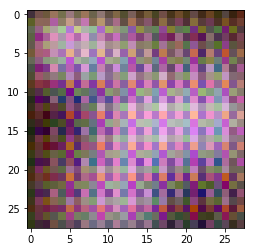

Epoch 1/20... Discriminator Loss: 0.5028... Generator Loss: 2.5173
Epoch 2/20... Discriminator Loss: 1.1331... Generator Loss: 1.6506
Epoch 2/20... Discriminator Loss: 0.6212... Generator Loss: 1.6211
Epoch 2/20... Discriminator Loss: 0.7463... Generator Loss: 1.4078
Epoch 2/20... Discriminator Loss: 0.8780... Generator Loss: 1.3575
Epoch 2/20... Discriminator Loss: 1.3040... Generator Loss: 0.6455
Epoch 2/20... Discriminator Loss: 1.1684... Generator Loss: 1.0945
Epoch 2/20... Discriminator Loss: 0.8592... Generator Loss: 1.5702
Epoch 2/20... Discriminator Loss: 1.1594... Generator Loss: 0.7423
Epoch 2/20... Discriminator Loss: 1.5421... Generator Loss: 0.8772


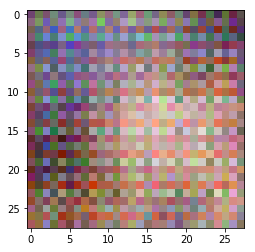

Epoch 2/20... Discriminator Loss: 0.8088... Generator Loss: 1.2454
Epoch 2/20... Discriminator Loss: 1.1780... Generator Loss: 0.6822
Epoch 3/20... Discriminator Loss: 1.6695... Generator Loss: 1.2412
Epoch 3/20... Discriminator Loss: 1.2397... Generator Loss: 0.9484
Epoch 3/20... Discriminator Loss: 1.6385... Generator Loss: 0.5919
Epoch 3/20... Discriminator Loss: 0.8536... Generator Loss: 1.0571
Epoch 3/20... Discriminator Loss: 1.6824... Generator Loss: 0.4205
Epoch 3/20... Discriminator Loss: 0.4358... Generator Loss: 3.8128
Epoch 3/20... Discriminator Loss: 1.2407... Generator Loss: 0.6605
Epoch 3/20... Discriminator Loss: 1.1572... Generator Loss: 3.2484


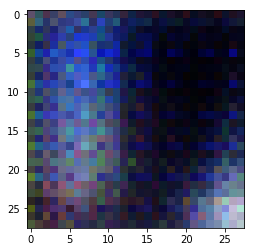

Epoch 3/20... Discriminator Loss: 0.6414... Generator Loss: 1.6236
Epoch 3/20... Discriminator Loss: 1.0996... Generator Loss: 0.9915
Epoch 3/20... Discriminator Loss: 2.0879... Generator Loss: 0.3700
Epoch 4/20... Discriminator Loss: 1.4549... Generator Loss: 2.1377
Epoch 4/20... Discriminator Loss: 1.4540... Generator Loss: 1.1611
Epoch 4/20... Discriminator Loss: 1.1074... Generator Loss: 0.7941
Epoch 4/20... Discriminator Loss: 1.4371... Generator Loss: 0.7862
Epoch 4/20... Discriminator Loss: 1.3520... Generator Loss: 0.6988
Epoch 4/20... Discriminator Loss: 1.3414... Generator Loss: 1.0510
Epoch 4/20... Discriminator Loss: 1.2738... Generator Loss: 0.8139


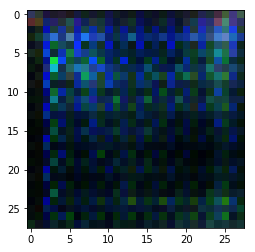

Epoch 4/20... Discriminator Loss: 1.1460... Generator Loss: 0.8091
Epoch 4/20... Discriminator Loss: 1.2393... Generator Loss: 0.8212
Epoch 4/20... Discriminator Loss: 1.3366... Generator Loss: 0.7713
Epoch 4/20... Discriminator Loss: 1.2983... Generator Loss: 0.7759
Epoch 5/20... Discriminator Loss: 1.2961... Generator Loss: 0.7502
Epoch 5/20... Discriminator Loss: 1.2444... Generator Loss: 0.8628
Epoch 5/20... Discriminator Loss: 1.3536... Generator Loss: 0.9092
Epoch 5/20... Discriminator Loss: 1.1914... Generator Loss: 0.8473
Epoch 5/20... Discriminator Loss: 1.4304... Generator Loss: 0.7260
Epoch 5/20... Discriminator Loss: 1.1375... Generator Loss: 0.8115


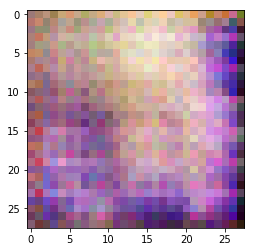

Epoch 5/20... Discriminator Loss: 1.1000... Generator Loss: 1.1110
Epoch 5/20... Discriminator Loss: 1.3503... Generator Loss: 0.8170
Epoch 5/20... Discriminator Loss: 1.2926... Generator Loss: 0.7718
Epoch 5/20... Discriminator Loss: 1.4645... Generator Loss: 0.7160
Epoch 5/20... Discriminator Loss: 1.3324... Generator Loss: 0.7235
Epoch 6/20... Discriminator Loss: 1.3253... Generator Loss: 0.7901
Epoch 6/20... Discriminator Loss: 1.1172... Generator Loss: 0.9429
Epoch 6/20... Discriminator Loss: 1.4640... Generator Loss: 0.7160
Epoch 6/20... Discriminator Loss: 1.3838... Generator Loss: 0.7608
Epoch 6/20... Discriminator Loss: 1.5006... Generator Loss: 0.7143


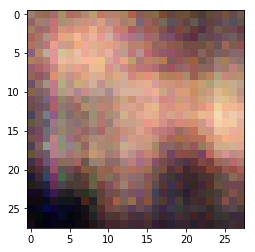

Epoch 6/20... Discriminator Loss: 1.4258... Generator Loss: 0.7152
Epoch 6/20... Discriminator Loss: 1.2200... Generator Loss: 0.8148
Epoch 6/20... Discriminator Loss: 1.4466... Generator Loss: 0.7027
Epoch 6/20... Discriminator Loss: 1.4772... Generator Loss: 0.7474
Epoch 6/20... Discriminator Loss: 1.4556... Generator Loss: 0.7365
Epoch 6/20... Discriminator Loss: 1.3768... Generator Loss: 0.7803
Epoch 7/20... Discriminator Loss: 1.1872... Generator Loss: 0.8291
Epoch 7/20... Discriminator Loss: 1.2736... Generator Loss: 0.8101
Epoch 7/20... Discriminator Loss: 1.3782... Generator Loss: 0.7554
Epoch 7/20... Discriminator Loss: 1.3356... Generator Loss: 0.8347


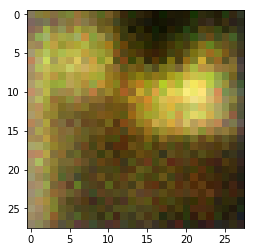

Epoch 7/20... Discriminator Loss: 1.2677... Generator Loss: 0.8083
Epoch 7/20... Discriminator Loss: 1.3577... Generator Loss: 0.8452
Epoch 7/20... Discriminator Loss: 1.4437... Generator Loss: 0.7265
Epoch 7/20... Discriminator Loss: 1.2941... Generator Loss: 0.8407
Epoch 7/20... Discriminator Loss: 1.3641... Generator Loss: 0.7855
Epoch 7/20... Discriminator Loss: 1.3240... Generator Loss: 0.8414
Epoch 7/20... Discriminator Loss: 1.1549... Generator Loss: 0.9437
Epoch 8/20... Discriminator Loss: 1.3525... Generator Loss: 0.8922
Epoch 8/20... Discriminator Loss: 1.2136... Generator Loss: 0.8586
Epoch 8/20... Discriminator Loss: 1.4331... Generator Loss: 0.7066


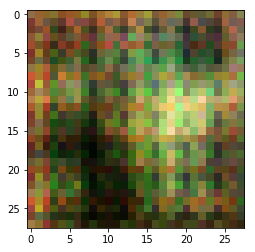

Epoch 8/20... Discriminator Loss: 1.4353... Generator Loss: 0.7512
Epoch 8/20... Discriminator Loss: 1.2590... Generator Loss: 0.8190
Epoch 8/20... Discriminator Loss: 1.1931... Generator Loss: 0.9105
Epoch 8/20... Discriminator Loss: 1.2857... Generator Loss: 0.8074
Epoch 8/20... Discriminator Loss: 1.2727... Generator Loss: 0.7673
Epoch 8/20... Discriminator Loss: 1.4256... Generator Loss: 0.7607
Epoch 8/20... Discriminator Loss: 1.4038... Generator Loss: 0.7175
Epoch 8/20... Discriminator Loss: 1.3356... Generator Loss: 0.7571
Epoch 9/20... Discriminator Loss: 1.3155... Generator Loss: 0.7676
Epoch 9/20... Discriminator Loss: 1.1056... Generator Loss: 0.9630


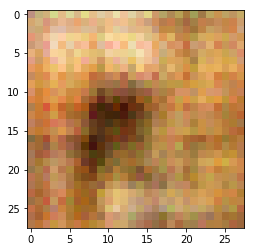

Epoch 9/20... Discriminator Loss: 1.4832... Generator Loss: 0.7690
Epoch 9/20... Discriminator Loss: 1.2655... Generator Loss: 0.7561
Epoch 9/20... Discriminator Loss: 1.3089... Generator Loss: 0.7969
Epoch 9/20... Discriminator Loss: 1.4956... Generator Loss: 0.6128
Epoch 9/20... Discriminator Loss: 1.4875... Generator Loss: 0.7211
Epoch 9/20... Discriminator Loss: 1.3794... Generator Loss: 0.7864
Epoch 9/20... Discriminator Loss: 1.3446... Generator Loss: 0.8548
Epoch 9/20... Discriminator Loss: 1.3268... Generator Loss: 0.7823
Epoch 9/20... Discriminator Loss: 1.1737... Generator Loss: 0.8916
Epoch 10/20... Discriminator Loss: 1.2173... Generator Loss: 0.8509


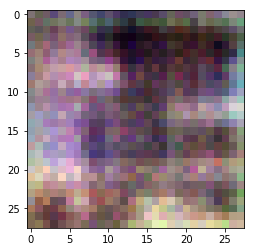

Epoch 10/20... Discriminator Loss: 1.1567... Generator Loss: 0.9173
Epoch 10/20... Discriminator Loss: 1.3664... Generator Loss: 0.8961
Epoch 10/20... Discriminator Loss: 1.3436... Generator Loss: 0.7654
Epoch 10/20... Discriminator Loss: 1.4557... Generator Loss: 0.7432
Epoch 10/20... Discriminator Loss: 1.4365... Generator Loss: 0.7595
Epoch 10/20... Discriminator Loss: 1.2977... Generator Loss: 0.7604
Epoch 10/20... Discriminator Loss: 1.1445... Generator Loss: 0.9007
Epoch 10/20... Discriminator Loss: 1.3905... Generator Loss: 0.7963
Epoch 10/20... Discriminator Loss: 1.4227... Generator Loss: 0.7833
Epoch 10/20... Discriminator Loss: 1.4452... Generator Loss: 0.6794


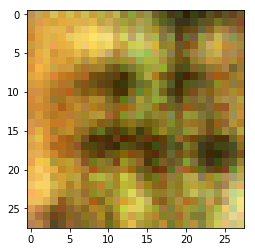

Epoch 10/20... Discriminator Loss: 1.4699... Generator Loss: 0.6774
Epoch 11/20... Discriminator Loss: 1.4820... Generator Loss: 0.6631
Epoch 11/20... Discriminator Loss: 1.3309... Generator Loss: 0.7683
Epoch 11/20... Discriminator Loss: 1.2720... Generator Loss: 0.8137
Epoch 11/20... Discriminator Loss: 1.5938... Generator Loss: 0.6854
Epoch 11/20... Discriminator Loss: 1.1554... Generator Loss: 0.9784
Epoch 11/20... Discriminator Loss: 1.3575... Generator Loss: 0.8142
Epoch 11/20... Discriminator Loss: 1.3925... Generator Loss: 0.7144
Epoch 11/20... Discriminator Loss: 1.4478... Generator Loss: 0.6692
Epoch 11/20... Discriminator Loss: 1.3037... Generator Loss: 0.8082


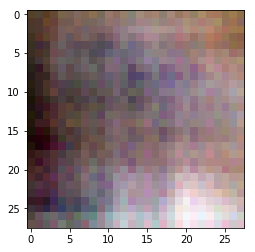

Epoch 11/20... Discriminator Loss: 1.3299... Generator Loss: 0.7797
Epoch 11/20... Discriminator Loss: 1.2377... Generator Loss: 0.7651
Epoch 12/20... Discriminator Loss: 1.4701... Generator Loss: 0.6871
Epoch 12/20... Discriminator Loss: 1.2883... Generator Loss: 0.7648
Epoch 12/20... Discriminator Loss: 1.4206... Generator Loss: 0.7618
Epoch 12/20... Discriminator Loss: 1.6774... Generator Loss: 0.7370
Epoch 12/20... Discriminator Loss: 1.5061... Generator Loss: 0.7922
Epoch 12/20... Discriminator Loss: 1.3230... Generator Loss: 0.8007
Epoch 12/20... Discriminator Loss: 1.4985... Generator Loss: 0.7981
Epoch 12/20... Discriminator Loss: 1.5222... Generator Loss: 0.6967


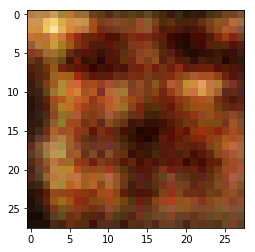

Epoch 12/20... Discriminator Loss: 1.1402... Generator Loss: 0.9024
Epoch 12/20... Discriminator Loss: 1.2420... Generator Loss: 0.8673
Epoch 12/20... Discriminator Loss: 1.2365... Generator Loss: 0.8039
Epoch 13/20... Discriminator Loss: 1.4289... Generator Loss: 0.8172
Epoch 13/20... Discriminator Loss: 1.4471... Generator Loss: 0.7378
Epoch 13/20... Discriminator Loss: 1.3085... Generator Loss: 0.7460
Epoch 13/20... Discriminator Loss: 1.3452... Generator Loss: 0.7994
Epoch 13/20... Discriminator Loss: 1.4438... Generator Loss: 0.7902
Epoch 13/20... Discriminator Loss: 1.3122... Generator Loss: 0.8253
Epoch 13/20... Discriminator Loss: 1.2973... Generator Loss: 0.8072


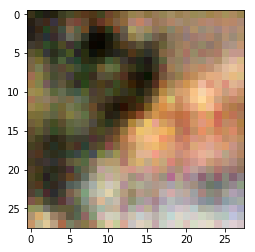

Epoch 13/20... Discriminator Loss: 1.2766... Generator Loss: 0.8797
Epoch 13/20... Discriminator Loss: 1.2720... Generator Loss: 0.8769
Epoch 13/20... Discriminator Loss: 1.5255... Generator Loss: 0.6570
Epoch 13/20... Discriminator Loss: 1.2651... Generator Loss: 0.8461
Epoch 14/20... Discriminator Loss: 1.2505... Generator Loss: 0.8000
Epoch 14/20... Discriminator Loss: 1.4166... Generator Loss: 0.7080
Epoch 14/20... Discriminator Loss: 1.6837... Generator Loss: 0.4997
Epoch 14/20... Discriminator Loss: 1.5228... Generator Loss: 0.7826
Epoch 14/20... Discriminator Loss: 1.3631... Generator Loss: 0.6874
Epoch 14/20... Discriminator Loss: 1.3820... Generator Loss: 0.6275


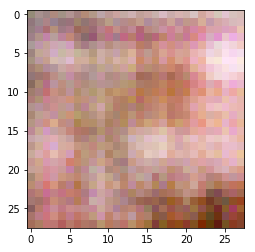

Epoch 14/20... Discriminator Loss: 0.9297... Generator Loss: 1.0287
Epoch 14/20... Discriminator Loss: 1.2499... Generator Loss: 0.7475
Epoch 14/20... Discriminator Loss: 1.3185... Generator Loss: 0.9503
Epoch 14/20... Discriminator Loss: 1.2016... Generator Loss: 0.7783
Epoch 14/20... Discriminator Loss: 1.3681... Generator Loss: 0.7558
Epoch 15/20... Discriminator Loss: 1.3880... Generator Loss: 0.6233
Epoch 15/20... Discriminator Loss: 1.4599... Generator Loss: 0.6599
Epoch 15/20... Discriminator Loss: 1.1843... Generator Loss: 0.8686
Epoch 15/20... Discriminator Loss: 1.4387... Generator Loss: 0.6576
Epoch 15/20... Discriminator Loss: 1.2651... Generator Loss: 0.8940


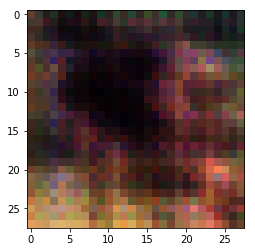

Epoch 15/20... Discriminator Loss: 1.3932... Generator Loss: 0.6657
Epoch 15/20... Discriminator Loss: 1.2435... Generator Loss: 0.8613
Epoch 15/20... Discriminator Loss: 1.3803... Generator Loss: 0.8028
Epoch 15/20... Discriminator Loss: 1.5448... Generator Loss: 0.6778
Epoch 15/20... Discriminator Loss: 1.7604... Generator Loss: 0.5729
Epoch 15/20... Discriminator Loss: 1.7859... Generator Loss: 0.6442
Epoch 16/20... Discriminator Loss: 1.4469... Generator Loss: 0.7742
Epoch 16/20... Discriminator Loss: 1.5182... Generator Loss: 0.7111
Epoch 16/20... Discriminator Loss: 1.2748... Generator Loss: 0.8099
Epoch 16/20... Discriminator Loss: 1.3051... Generator Loss: 0.7989


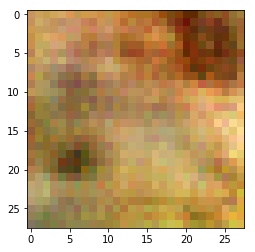

Epoch 16/20... Discriminator Loss: 1.2541... Generator Loss: 0.8835
Epoch 16/20... Discriminator Loss: 1.2359... Generator Loss: 0.8700
Epoch 16/20... Discriminator Loss: 1.3856... Generator Loss: 0.7450
Epoch 16/20... Discriminator Loss: 1.3558... Generator Loss: 0.7832
Epoch 16/20... Discriminator Loss: 1.4901... Generator Loss: 0.6953
Epoch 16/20... Discriminator Loss: 1.4530... Generator Loss: 0.6793
Epoch 16/20... Discriminator Loss: 1.1703... Generator Loss: 0.8501
Epoch 17/20... Discriminator Loss: 1.1916... Generator Loss: 0.9820
Epoch 17/20... Discriminator Loss: 1.2154... Generator Loss: 0.7728
Epoch 17/20... Discriminator Loss: 1.2692... Generator Loss: 0.7661


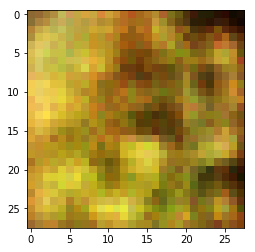

Epoch 17/20... Discriminator Loss: 1.4026... Generator Loss: 0.8162
Epoch 17/20... Discriminator Loss: 1.3576... Generator Loss: 0.7846
Epoch 17/20... Discriminator Loss: 1.3548... Generator Loss: 0.7385
Epoch 17/20... Discriminator Loss: 1.3888... Generator Loss: 0.7168
Epoch 17/20... Discriminator Loss: 1.4847... Generator Loss: 0.6982
Epoch 17/20... Discriminator Loss: 1.4115... Generator Loss: 0.7222
Epoch 17/20... Discriminator Loss: 1.2587... Generator Loss: 0.9084
Epoch 17/20... Discriminator Loss: 1.3506... Generator Loss: 0.7744
Epoch 18/20... Discriminator Loss: 1.4214... Generator Loss: 0.7925
Epoch 18/20... Discriminator Loss: 1.2007... Generator Loss: 0.8881


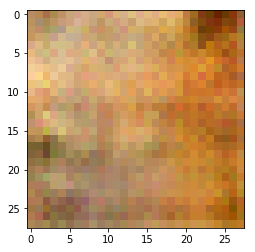

Epoch 18/20... Discriminator Loss: 1.4717... Generator Loss: 0.7109
Epoch 18/20... Discriminator Loss: 1.3529... Generator Loss: 0.7401
Epoch 18/20... Discriminator Loss: 1.5101... Generator Loss: 0.7356
Epoch 18/20... Discriminator Loss: 1.3223... Generator Loss: 0.8553
Epoch 18/20... Discriminator Loss: 1.3107... Generator Loss: 0.8055
Epoch 18/20... Discriminator Loss: 1.3649... Generator Loss: 0.7424
Epoch 18/20... Discriminator Loss: 1.3600... Generator Loss: 0.8021
Epoch 18/20... Discriminator Loss: 1.3105... Generator Loss: 0.7572
Epoch 18/20... Discriminator Loss: 1.4249... Generator Loss: 0.7021
Epoch 19/20... Discriminator Loss: 1.4115... Generator Loss: 0.8330


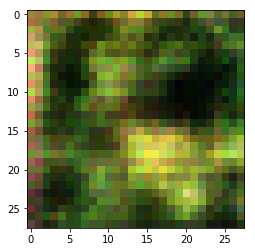

Epoch 19/20... Discriminator Loss: 1.2613... Generator Loss: 0.8836
Epoch 19/20... Discriminator Loss: 1.3712... Generator Loss: 0.7766
Epoch 19/20... Discriminator Loss: 1.4687... Generator Loss: 0.7693
Epoch 19/20... Discriminator Loss: 1.2749... Generator Loss: 0.7908
Epoch 19/20... Discriminator Loss: 1.5026... Generator Loss: 0.6365
Epoch 19/20... Discriminator Loss: 1.4000... Generator Loss: 0.7843
Epoch 19/20... Discriminator Loss: 1.2922... Generator Loss: 0.8968
Epoch 19/20... Discriminator Loss: 1.4322... Generator Loss: 0.7928
Epoch 19/20... Discriminator Loss: 1.3719... Generator Loss: 0.7968
Epoch 19/20... Discriminator Loss: 1.3788... Generator Loss: 0.8581


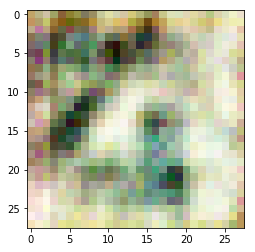

Epoch 20/20... Discriminator Loss: 1.2366... Generator Loss: 0.8172
Epoch 20/20... Discriminator Loss: 1.2335... Generator Loss: 0.8335
Epoch 20/20... Discriminator Loss: 1.3508... Generator Loss: 0.8634
Epoch 20/20... Discriminator Loss: 1.2893... Generator Loss: 0.8970
Epoch 20/20... Discriminator Loss: 1.6249... Generator Loss: 0.6533
Epoch 20/20... Discriminator Loss: 1.4714... Generator Loss: 0.7549
Epoch 20/20... Discriminator Loss: 1.2639... Generator Loss: 0.7930
Epoch 20/20... Discriminator Loss: 1.2517... Generator Loss: 0.8144
Epoch 20/20... Discriminator Loss: 1.2910... Generator Loss: 0.7974
Epoch 20/20... Discriminator Loss: 1.2564... Generator Loss: 0.8286


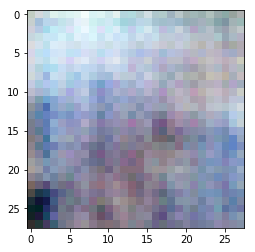

Epoch 20/20... Discriminator Loss: 1.3066... Generator Loss: 0.7450
Epoch 20/20... Discriminator Loss: 1.4161... Generator Loss: 0.7428


In [32]:
batch_size = 30
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

epochs = 20

impre_dataset = helper.Dataset('impressionism', glob(os.path.join(data_dir, 'impressionism/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, impre_dataset.get_batches,
          impre_dataset.shape, impre_dataset.image_mode)